# Imports and Moving into Directory

In [8]:
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import os

If using Google Colab run the following code block

In [9]:
from google.colab import drive 
drive.mount('/content/gdrive')

#Move to the notebook working directory
%cd /content/gdrive/MyDrive/Bioimage\ Informatics/Tracking

!pip install pims_nd2

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1KBLLeRYGQsIfkELFrExLiWHh1WVbHC7P/Bioimage Informatics/Tracking
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from image_processing import *
from auto_encoder_model import *

# Moving Image Files around and Testing Droplet Counting Code

In [ ]:
import shutil

dir = '/content/gdrive/MyDrive/Bioimage Informatics/denoise_results/Evan_4_3_1/150 epochs/images'
files = os.listdir(dir)

for f in files:
    if "fake" in f:
        shutil.copy(os.path.join(dir,f),'/content/gdrive/MyDrive/Bioimage Informatics/Tracking/Data/CycleGAN_Processed_Test_Images')

In [ ]:
trainFolder = '/content/gdrive/MyDrive/Bioimage Informatics/Tracking/Data/CycleGAN_Processed_Test_Images'
images = read_images_from_dir(trainFolder)

Read in 60 images with each image of shape (256, 256, 3)

The first image from the folder


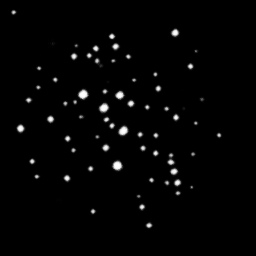

In [ ]:
print(f"Read in {len(images)} images with each image of shape {images[0].shape}\n")

print("The first image from the folder")
cv2_imshow(images[11])

In [11]:
outPath = '/content/gdrive/MyDrive/Bioimage Informatics/Tracking/Data/Auto_Encoder_Droplet_Images/'

In [ ]:
imgCentroids = []
max = 0 

count = 0
for img in images:

    #detect droplet, store centroid location
    dropletDims, dropletCentroids = detect_droplets(img[:,:,0])

    if np.max(dropletDims[:,0:2]) > max:
        max = np.max(dropletDims[:,0:2])

    imgCentroids.append(dropletCentroids)
    
    #crop each individual droplet , save to file
    dropletImgs = crop_droplets(img[:,:,0], dropletDims,count,outPath,save = True)
    count += len(dropletImgs)

In [ ]:
print(f"The bounding with largest single dimension was of size {max} pixels")

The bounding with largest single dimension was of size 39 pixels


# Training the AutoEncoder

In [12]:
import torch
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot  as plt

In [14]:
images = []
for f in os.listdir(outPath):

    images.append(cv2.imread(os.path.join(outPath,f),cv2.IMREAD_GRAYSCALE))

Normalize the Image Data

In [15]:
data = DropletImageData(images,40)

imagesNormalize = data[0]
for i in range(1,len(data)):
    imagesNormalize = np.vstack((imagesNormalize,data[i]))

imagesNormalize = imagesNormalize.reshape(-1,40,40) 
meanTrain = np.mean(imagesNormalize,axis = 0)
stdTrain = np.std(imagesNormalize,axis = 0) + 1e-10

imagesNormalize = (imagesNormalize - meanTrain) / stdTrain

In [16]:
#Training config dictionary, k arg is used to determine knn adj matrix 
config = dict(encodingDim = 15,max = 40, batch_size = 32, epochs = 50,
              learning_rate = .01,modelPath = 'trained_model.pt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
#Split data into train, validation, and test set
X_train, X_test = train_test_split(imagesNormalize,train_size = .8,shuffle = True)
X_train,X_val  = train_test_split(X_train,train_size = .8,shuffle = True)


trainData = DropletImageData(X_train,config['max'])
train_args = dict(shuffle = True, batch_size = 32, num_workers= 8,drop_last = False, pin_memory = False)
train_loader = DataLoader(trainData,**train_args)

valData = DropletImageData(X_val,config['max'])
val_args = dict(shuffle = True, batch_size = 32, num_workers= 8,drop_last = False, pin_memory = False)
val_loader = DataLoader(valData,**val_args)



print("Number of samples in training set:",len(trainData))
print("Number of samples in validation set:",len(valData))

Number of samples in training set: 3158
Number of samples in validation set: 790


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
model = AutoEncoder(1,config['encodingDim'])
model.to(device)

optim = torch.optim.Adam(model.parameters(),lr = config['learning_rate'])

In [13]:
trainLoss = []
valLoss = []

with tqdm(range(config["epochs"]), unit= 'epoch') as tepoch:
  for e in tepoch:
      tepoch.set_description(f"Epoch {e}")

      trainLoss.append(train_one_epoch(train_loader,model,optim,device))
      valLoss.append(eval_one_epoch(val_loader,model,device))

      tepoch.set_postfix(train_loss = trainLoss[-1],val_loss = valLoss[-1])

#Save trained model
torch.save(model.state_dict(),config['modelPath'])

  0%|          | 0/50 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


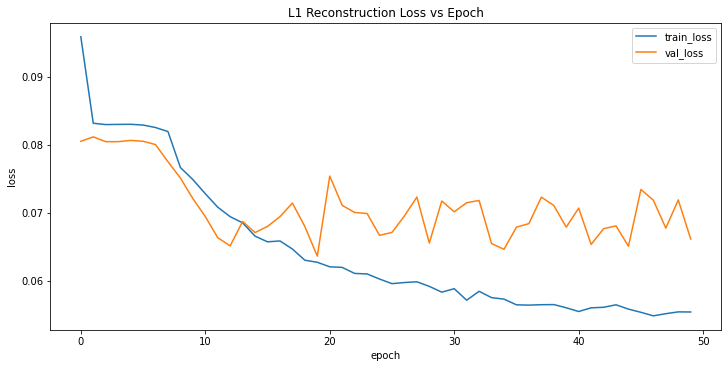

In [14]:
fig, ax = plt.subplots(1,1, sharex = True,figsize=(10,5),constrained_layout = True)
ax.plot(np.arange(len(trainLoss)),trainLoss,label = "train_loss")
ax.plot(np.arange(len(valLoss)),valLoss,label = "val_loss")
ax.set_title("L1 Reconstruction Loss vs Epoch")
ax.set(ylabel='loss')
ax.set(xlabel='epoch')
ax.legend()

# Qualitative Evaluation of the "Test" Images ie. 60 frame video

In [7]:
testData = DropletImageData(X_test,config['max'])
test_args = dict(shuffle = False, batch_size = 32, num_workers= 8,drop_last = False, pin_memory = False)
test_loader = DataLoader(testData,**test_args)

NameError: ignored

In [6]:
preds = []
imgs = []

model = AutoEncoder(1,config['encodingDim']) 
model.load_state_dict(torch.load(config["modelPath"]))
model.to(device)
model.eval()

for X in test_loader:
    imgs.extend(X.numpy())

    X = X.to(device)
    X = X.unsqueeze(1)
    preds.extend(model(X).squeeze(1).cpu().detach().numpy())

NameError: ignored

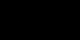

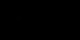

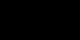

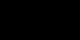

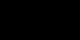

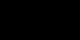

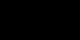

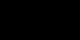

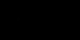

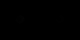

In [17]:
for i in range(10):
    cv2_imshow(np.hstack((imgs[i],preds[i])))

# Network Flow Formulation

In [5]:
import networkx as nx

Functions to add edges <br>
s -> u <br> 
u -> v <br>
v -> t <br>
v in frame t -> u in frame t + 1 <br>


In [94]:
def add_s_t_self_edges(G,nodes):

    #iterate over the new objects to add 
    for i in nodes:
      G.add_edge('s',f'u_{i}', capacity = 1, weight =  1500)
      G.add_edge(f'u_{i}',f'v_{i}',capacity = 1, weight = 1)
      G.add_edge(f'v_{i}','t',capacity = 1, weight = 1500) ### the weight here could be an important parameter to play with


In [76]:
def add_fully_connected_edges(G,nodesPre,nodesPost):
    max = 0 

    for i in range(len(nodesPre)):
        for j in range(len(nodesPost)):
            edgeWeight = np.linalg.norm(nodesPre[i] - nodesPost[j])
            G.add_edge(f'v_{i}',f'u_{j}', capacity = 1, weight = edgeWeight)

            if edgeWeight > max:
                max = edgeWeight

    return max

Read in all of the test images from a video

In [18]:
testFolder = '/content/gdrive/MyDrive/Bioimage Informatics/Tracking/Data/CycleGAN_Processed_Test_Images'
images = read_images_from_dir(testFolder)

print(f"There are {len(images)} frames in the folder")

There are 60 frames in the folder


Load the trained model, set the model to eval , and set the device

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoEncoder(1,config['encodingDim']) 
model.load_state_dict(torch.load(config["modelPath"]))
model.to(device)
model.eval()

AutoEncoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (convLayers): ModuleList(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
      (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    )
    (bn1_dec): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2_dec): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3_dec): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn_dec): ModuleList(
      (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_r

## Main Loop Here
<br>
1. Construct a Directed Graph with source node s and sink node t <br>
2. Iterate through each image <br>
  a. detect the droplets in the image, obtaining centroids/bounding box dims <br>
  b. crop the droplets from the original image <br>
  c. extract encoder features for each droplet image <br>
  d. add each type of edge to the directed graph

In [95]:
numDropsPerFrame = []
maxDist = 0

centroids = []
boundingBoxDims = []

#construct directed graph, source and sink nodes
G = nx.DiGraph()
G.add_nodes_from(['s','t'])

count = 0

#Detect droplets, crop, get features from auto encoder, add edges to graph
for i,img in enumerate(images):
    
    if i  == 0:
        #detect droplet, store centroid location
        dropletDims, dropletCentroids = detect_droplets(img[:,:,0])

        dropletDimsMat = dropletDims
        dropletCentroidsMat = dropletCentroids
        numDropsPerFrame.append((count,count + len(dropletDims)))
        
        #crop each individual droplet
        dropletImgs = crop_droplets(img[:,:,0], dropletDims,0)

        #set up dataloader because it already has the pad function
        testData = DropletImageData(dropletImgs,config['max'])
        test_args = dict(shuffle = False, batch_size = 1, num_workers= 8,drop_last = False, pin_memory = False)
        test_loader = DataLoader(testData,**test_args)


        #encode the droplet image
        dropletFeaturesPre = []
        for X in test_loader:
            X = (X - torch.tensor(meanTrain)) / torch.tensor(stdTrain)
            X = X.to(device)
            X = X.unsqueeze(1)
            dropletFeaturesPre.append(model.encoder(X).cpu().detach().numpy().squeeze(0))

        #add s,t, and self edges to directed graph
        add_s_t_self_edges(G,np.arange(count,count + len(dropletDims)))
        count += len(dropletDims)


    else:
          #detect droplet, store centroid location
        dropletDims, dropletCentroids = detect_droplets(img[:,:,0])

        dropletDimsMat = np.vstack((dropletDimsMat,dropletDims))
        dropletCentroidsMat = np.vstack((dropletCentroidsMat,dropletCentroids))

        numDropsPerFrame.append((count,count + len(dropletDims)))


        #crop each individual droplet
        dropletImgs = crop_droplets(img[:,:,0], dropletDims,0)

        #set up dataloader because it already has the pad function
        testData = DropletImageData(dropletImgs,config['max'])
        test_args = dict(shuffle = False, batch_size = 1, num_workers= 8,drop_last = False, pin_memory = False)
        test_loader = DataLoader(testData,**test_args)


        #encode the droplet image
        dropletFeaturesPost = []
        for X in test_loader:
            X = (X - torch.tensor(meanTrain)) / torch.tensor(stdTrain)
            X = X.to(device)
            X = X.unsqueeze(1)
            dropletFeaturesPost.append(model.encoder(X).cpu().detach().numpy().squeeze(0))

        #add s,t, and self edges to directed graph
        add_s_t_self_edges(G,np.arange(count,count + len(dropletDims)))
        weight = add_fully_connected_edges(G,dropletFeaturesPre,dropletFeaturesPost)
        
        if weight > maxDist:

            maxDist = weight
        count += len(dropletDims)
        dropletFeaturesPre = dropletFeaturesPost


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [65]:
np.max(dropletFeaturesPost)

6216.8696

# Obtain Max Flow Min Cost Solution 

In [34]:
class Trajectory():

  def __init__(self,start,end,centroids,dims):

      self.start_frame = start
      self.end_frame = end

      self.centroids = centroids
      self.box_Dims = dims

In [96]:
solution = nx.max_flow_min_cost(G,'s','t')
solGraph = nx.Graph()

#iterate over every node in the solution
for node in solution:

    #maintain a list of used eges (node to k)
    edges = [(node,k) for k,v in solution[node].items() if v > 0]
    solGraph.add_edges_from(edges)

In [97]:
#Obtain the list of nodes that were added to G in order in which they were added
sortedNodes = list(G.nodes)

#delete source and sink node
del sortedNodes[0]
del sortedNodes[0]

Get the individual trajectories

In [98]:
c = 0 
trajs = [] 

while c < count:

    node = sortedNodes[0]
    traj = nx.shortest_path(solGraph,node, target = 't')[:-1] #remove sink node

    for subNode in traj:
        sortedNodes.remove(subNode)

    tmp = []
    for i, string in enumerate(traj):
        if i % 2 == 0:
          tmp.append(int(string.split("_")[-1]))
   
    trajs.append(tmp)
    
    c += len(traj)/2

Create a list of trajectory Objects which store the start/end frame number, list of centroids, and list of bounding box dims 

In [99]:
trajObjs = []

for traj in trajs:
    startNode = traj[0]
    endNode = traj[-1]

    for i,count in enumerate(numDropsPerFrame):
        if startNode in range(count[0],count[1]):
          start = i
          break
    
    for i,count in enumerate(numDropsPerFrame):
        if endNode in range(count[0],count[1]):
          end = i
          break
    
        
    trajObjs.append(Trajectory(start,end,dropletCentroidsMat[traj],dropletDimsMat[traj]))

In [100]:
len(trajs)

4935